# Project 2: Sequence Alignment and Phylogeny


   <div class="alert alert-block alert-danger">
    <center>Due: <b>Wednesday, 21 September, 8:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    For this assignment, you are encouraged to work with one other person. Your team must satisfy these constraints:
    
   1. You **did not work together on Project 1**.
   2. You and your partner have a **total number of siblings that is divisible by two** (e.g., if you have one sibling, you need to find a partner with 1, 3, 5, or 7 siblings. If anyone has more than 7 siblings, they can partner with anyone!)
    
We expect most students will have the best learning experience on this assignment by working with a partner, but if you prefer to work alone it is permissible to do this assignment on your own.
    
You are encouraged to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from any other students in the class (other than your collaboration with your partner) or from previous offerings of this course, and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. 

You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>
</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
</div>

 <div class="alert alert-block alert-warning">
    
<b>Submission</b>: Please submit the code you wrote to generate your answers for all parts using this form: https://forms.gle/gv144kv3KRo67uUX7. Your answers should be in the Jupyter Notebook, along with your code. Before submission, you should make a copy of your notebook file with the name uvaid1\_uvaid2.ipynb (where uvaidn is each teammates UVA id) so the submitted file identifies you. You and your partner should submit a single file once together. Submission is due 8:59 pm on Wednesday, 21 September.

## Getting Started

Install basic required packages, should be run only once. You may need to restart the jupyter python kernel (under the Kernel menu) after this. (You can execute this directly in the notebook but running the command below.)

In [2]:
%pip install -r requirements.txt

  Cloning https://github.com/iamgroot42/blosum.git to /private/var/folders/64/sjn66_757r9fmzm8cv1thdgw0000gn/T/pip-req-build-ssxtg37e
  Running command git clone --filter=blob:none --quiet https://github.com/iamgroot42/blosum.git /private/var/folders/64/sjn66_757r9fmzm8cv1thdgw0000gn/T/pip-req-build-ssxtg37e
  Resolved https://github.com/iamgroot42/blosum.git to commit 433ed2f1b55fa010ad1b4b2a84158c1f38ddeaf6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import blosum as bl
import networkx as nx
import matplotlib.pyplot as plt
import utils
from itertools import chain

## Part 1: Global Sequence Alignment

Below we provide the sequence alignment code from [Class 6](https://computingbiology.github.io/class6/). You are welcome to use and modify this code however you want in your solution, but should answer the questions below based on this provided code.

In [4]:
def simpleMatch(a, b):
    return 1 if a == b else -1

def distanceMatch(a, b):
    return 0 if a == b else -1

def linearGap(n):
    return -1 * n

def alignmentScore(s1, s2, gapPenalty, match):
    if not s1 or not s2:
        return gapPenalty(len(s1)) + gapPenalty(len(s2))
    else:
        return max(gapPenalty(1) + alignmentScore(s1, s2[1:], gapPenalty, match), 
                   gapPenalty(1) + alignmentScore(s1[1:], s2, gapPenalty, match),
                   match(s1[0], s2[0]) + alignmentScore(s1[1:], s2[1:], gapPenalty, match)) 

In [5]:
def alignmentScoreDP(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(gapPenalty(1) + m[i, j - 1],  
                          gapPenalty(1) + m[i - 1, j],    
                          match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1]) 
    return m
    
def readAlignment(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = "" 
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            score += match(s1[i], s2[j])
            s1a = s1[i] + s1a
            if s1[i] == s2[j]:
                s2a = s2[j] + s2a
            else:
                s2a = s2[j].lower() + s2a
        elif i > 0 and m[i, j] == m[i - 1, j] + gapPenalty(1):
            i = i - 1
            score += gapPenalty(1)
            s1a = s1[i] + s1a
            s2a = '-' + s2a
        elif j > 0 and m[i, j] == m[i, j - 1] + gapPenalty(1):
            j = j - 1
            score += gapPenalty(1)
            s1a = '-' + s1a
            s2a = s2[j] + s2a
        else:
            assert False
    return (s1a, s2a, score)

def showAlignment(s1, s2, gapPenalty, match):
    m = alignmentScoreDP(s1, s2, gapPenalty, match)
    r = readAlignment(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [6]:
# Example
r = showAlignment("GATT", "GCAT", linearGap, simpleMatch)

G-ATT
GCA-T
1


Here's the version that supports affine gap penalties (from Class 6):

In [7]:
def alignmentScoreDPG(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):         
            m[i, j] = max(chain((gapPenalty(g) + m[i, j - g] for g in range(1, j + 1)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i + 1)),   
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
    return m
    
def readAlignmentG(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = ""
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            s1a = s1[i] + s1a
            s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a
            score += match(s1[i], s2[j])
        else:
            foundit = False
            for g in range(1, i + 1):
                if m[i, j] == m[i - g, j] + gapPenalty(g):
                    s1a = s1[i - g:i] + s1a
                    s2a = ('-' * g) + s2a
                    i = i - g
                    score += gapPenalty(g)
                    foundit = True
                    break
            if not foundit:
                for g in range(1, j + 1):
                    if m[i, j] == m[i, j - g] + gapPenalty(g):
                        s1a = ('-' * g) + s1a
                        s2a = s2[j - g:j] + s2a
                        j = j - g
                        score += gapPenalty(g)
                        foundit = True
                        break
            assert foundit
    return (s1a, s2a, score)

def showAlignmentG(s1, s2, gapPenalty, match):
    m = alignmentScoreDPG(s1, s2, gapPenalty, match)
    r = readAlignmentG(s1, s2, m, gapPenalty, match)
    print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [8]:
def affineGap(n, gp = -1, gn = -0.2):
    return gp + (n - 1) * gn

In [9]:
# Example
s1 = "AAAGAATTCA"
s2 = "AAATCA"
r = showAlignmentG(s1, s2, affineGap, simpleMatch)

AAAGAATTCA
AAA----TCA
4.4


<div class="alert alert-success">

**Problem 1 (a).** Run the given algorithm to find a global sequence alignment for the OCA2 genes (a key gene for the production of melanin) for humans and mice with the following gap penalties (still using simpleMatch as the match score function):

  a. `linearGap` penalty
    
  b. `affineGap` penalty, with $gp=-0.2$

  c. `affineGap` penalty, with $gp=-0.1$
    
</div>


In [10]:
human_oca2, mouse_oca2 = utils.load_oca2_sequences()

In [11]:
# Your code here
linG = showAlignment(human_oca2, mouse_oca2, linearGap, simpleMatch)
def affineGap2(n, gp = -0.2, gn = -0.2):
    return gp + (n - 1) * gn
affG_2 = showAlignmentG(human_oca2, mouse_oca2, affineGap2, simpleMatch)
def affineGap3(n, gp = -0.1, gn = -0.2):
    return gp + (n - 1) * gn
affG_1 = showAlignmentG(human_oca2, mouse_oca2, affineGap3, simpleMatch)

-GTTCT--TACTTCGAAG-GCTGTGCTCCG----CTCACCATCCAGAGCGGAGGTGCGGACC-T-TA-AACTCA-CTCC--TGGA----GA-A--AGATCTGCAAGTGC-GCAGAGAGAAGACTGGCAGTGGAGCATGCATCTGGAGGGCAGAGACGGC-A-GGCGGTACCCCGGCGCGCCGGCG-GTGGAGCTCCTGCAGACGTCCGTGCC-CAGCGGACTCGCT-GAACTTGTGGC--CGGCA-AGC
CccTCTGGggCTgC-AAGTGC-cTGCTgaGAAATCTtA-CA-CC--AG-GGttGTGC--tCCATCcACgACTCAGagCCTTTGGATCTGGACACTAGA-CTtC-AcTGCTG--GAGAG-AGA-T--CAG-cGAG--T-CATC---A-GaCAGA-tCaGCAACGG-GG-A--CatGCGC-CtaGaGAacaaAG-aCaT-CAG--G-CtG-GCCTCAGCcG--T-GCTGGAAgTaG-aGCTACacCAGA-C
25
---------G-T-----T-C-T--T---A---CTT-CGA--A-GG-CTGTGCTCC--GCTCAC--CATCCAGAG-C---GGAGGTGC-GGAC-CTTAA-AC-TCACT-CCTGGAGA-AAGATC-TGC-AAGTGC--GCAGA-GAGA--AG--ACTGGCAGTGGAGCAT--GCATCT-G-G-AGGGC-AGAGAC--GGCAGGC-GGTACCC-C-GGCGCG-CCGGCGGTGG-AGCTCCTGCAGACGTCCGTGCCCAGCGGACTCGCTGAACTTGTGGCCGGCAAGC
CCCTCTGGGGCTGCAAGTGCCTGCTGAGAAATCTTAC-ACCAGGGT-TGTGCTCCAT-C-CACGAC-T-CAGAGCCTTTGGA--T-CTGGACACT--AGACTTCACTG-CTGGAGAG-AGATCA-GCG-AGT-CAT-CAGAC-AGATCAGCAAC-G---G-GGA-CATGCGC--CTAGAGAA---CAA-AGACAT--CAGGCTGG---CCT

<div class="alert alert-success">

**Problem 1 (b).** Use the given function to convert these sequences to their amino-acid sequences, and then re-run alignment for all sequences with the default parameters for `affineGap`.
</div>


In [12]:
# Convert sequence of nucleotides to amino acids using codon table lookup
# Example
utils.convert_to_amino("AAATGCGGCGTA")

'KCGV'

In [13]:
# Your code here
amino_human = utils.convert_to_amino(human_oca2)
amino_mouse = utils.convert_to_amino(mouse_oca2)
affG_2 = showAlignmentG(amino_human, amino_mouse, affineGap, simpleMatch)


VLTSKAVLRS-----------PSRAEVRTLNSL----L-----E------KDLQVR----RE----------KTGSGACIWRAETAGGTPARRRWSSCRRPCPADSLNLWPAS
--pSgA--aSAC_EILHQGCAPS-----TtqSLWIWTLDFTAGERSASHQtD-QqRGHAPREQRHQAGLSRA--GS-----RA-----TP--------------D--------
-13.799999999999999


## Part 2: Alignment with Amino-Acids


The PAM<em>n</em> matrix (to be covered in [Class 6](https://computingbiology.github.io/class6/)) represents the likelihood of the occurrence of each tranformation during a time period where there are _n_ total mutation events per 100 amino acids.

<div class="alert alert-success">

**Problem 2 (a)** What would a negative value of an entry in a PAM 1 matrix $M$ indicate? Explain in terms of evolution and functionality of the proteins. Note that $M_{ij} = log(\frac{q_{ij}}{p_ip_j})$ where $q_{ij}$ indicates the frequency of amino acids $i$ and $j$ observed to align in related sequences, and $p_i$ and $p_j$ represent the frequencies of occurrence of $i$ and $j$.
</div>

A negatvie value indicates that i and j are not related. This is because a negative value means that q_ij was smaller than p_i*p_j. This means that the frequency of i and j being observed in a related sequence is lower than the frequency of seeing i an j together by chance.

<div class="alert alert-success">
    
**Problem 2 (b).** The BLOSUM<em>x</em> matices are created by clustering sequences with more than <em>x</em>% similarity into one single sequence and comparing sequences with more than <em>x</em>% divergence. Therefore, BLOSUM matrices are based on local alignments. Which of BLOSUM 50 and 60 contain more evoluationary divergence? 
    
</div>

BLOSUM50. Since BLOSUM50 only compares based on 50% similarity, it will have less similarites compares to BLOSUM60 which compares based on 60% similairty. This will make it so that BLOSUM50 will have more divergence.

<div class="alert alert-success">

**Problem 2 (c).** Use the BLOSUM62 matrix as your scoring function to perform global alignment on the amino-acid sequences using `linearGap` (default parameters).
</div>

In [14]:
blosum_matrix = bl.BLOSUM(62)

In [15]:
# Your code here
def blosum_match(a,b):
    return blosum_matrix[a+b]

blosum_alignment = showAlignmentG(amino_human, amino_mouse, linearGap, blosum_match)

---VLTSKA---VL-R--SPSRAEVRTLNSL----LEKDLQVRREKTGSGACIWR-A--ET---AGGTPAR-RR-WS--SCRRPCPADSLNLWPAS
PSGa-aS-AC_EiLHqGCaPS---t-T-qSLWIWTL--Df------T-aGe---RSASHqTDQQrGhaP-REqRHqaGLS--R---AgS-ratP-d
68.0


<div class="alert alert-success">

**Problem 2 (d).** How do your results for Problem 2c differ from the earlier ones of Problem 1a (with `linearGap`)? Which one would you say is more biologically plausible?
</div>

1A had an alignment score of 25 and 2C had an alignment score of 68.

1A: -GTTCT--TACTTCGAAG-GCTGTGCTCCG----CTCACCATCCAGAGCGGAGGTGCGGACC-T-TA-AACTCA-CTCC--TGGA----GA-A--AGATCTGCAAGTGC-GCAGAGAGAAGACTGGCAGTGGAGCATGCATCTGGAGGGCAGAGACGGC-A-GGCGGTACCCCGGCGCGCCGGCG-GTGGAGCTCCTGCAGACGTCCGTGCC-CAGCGGACTCGCT-GAACTTGTGGC--CGGCA-AGC CccTCTGGggCTgC-AAGTGC-cTGCTgaGAAATCTtA-CA-CC--AG-GGttGTGC--tCCATCcACgACTCAGagCCTTTGGATCTGGACACTAGA-CTtC-AcTGCTG--GAGAG-AGA-T--CAG-cGAG--T-CATC---A-GaCAGA-tCaGCAACGG-GG-A--CatGCGC-CtaGaGAacaaAG-aCaT-CAG--G-CtG-GCCTCAGCcG--T-GCTGGAAgTaG-aGCTACacCAGA-C 25

2C: ---VLTSKA---VL-R--SPSRAEVRTLNSL----LEKDLQVRREKTGSGACIWR-A--ET---AGGTPAR-RR-WS--SCRRPCPADSLNLWPAS PSGa-aS-AC_EiLHqGCaPS---t-T-qSLWIWTL--Df------T-aGe---RSASHqTDQQrGhaP-REqRHqaGLS--R---AgS-ratP-d 68.0

Some nucleotide changes dont affect the amino acid becuase they do not change them or their functions. For example TTT and TTC would have a penalty in the nucleotide alignment but not in the amino acid alignment because both of them code to Phenylalanine. So 2c or the blosum score is more plausible

<div class="alert alert-success">

**Problem 2 (e).** We discussed in class that the PAM matrices follow the Markov property and a mismatch at any site depends only on the amino acid at that site and the transition probability. Is this a suitable representation of evolution? Think about if replacements are equaly likely to occur over entire sequences. It may help to consider the difference between PAM and BLOSUM matrices.
</div>

_Type your answer here_
ASK TA

This is indeed a suitable representation of evolution because the PAM matrices because PAM does not account for silent mutations. This means that the PAM matrix will read the sequence if it is the same and this is good because in real life the nucleotide changes do not affect the amino acid meaning it will not affect the way the protein acts or is encoded. Which makes this a suitable represenation of evolution. Replacements are likely to occur over entire sequences but they do tend to have some "hot spots" where they are more likely to mutate and be replaced. 

## Part 3: Local Sequence Alignment


<div class="alert alert-success">
    
<b>Problem 3 (a).</b> Implement local alignment (for both the normal and affine-gap penalties) using the Smith-Waterman algorithm. Feel free to re-use and modify the given Needleman–Wunsch algorithm. 
</div>

In [13]:
# def showAlignmentLocal(s1, s2, gapPenalty, match):
#     # Although it is often useful to return all high scoring local alignments for an input pair, 
#     # it is sufficient if your algorithm just returns the single highest-scoring local alignment 
#     # (as shown in the examples below).
    
#     # Your code here (implement)
#     pass
def alignmentScoreDPGL(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    for i in range(1, len(s1) + 1):
        m[i, 0] = 0
    for j in range(1, len(s2) + 1):
        m[0, j] = 0
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1): 
            m[i, j] = max(chain((gapPenalty(g) + m[i, j - g] for g in range(1, j + 1)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i + 1)),   
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
            m[i,j] = 0 if m[i,j] < 0 else m[i,j]
  
    return m



def readAlignmentGL(s1, s2, m, gapPenalty, match):
    i,j = np.unravel_index(m.argmax(),m.shape)
    s1a = ""
    s2a = ""
    score = 0
    
    while (i > 0 or j > 0) and m[i, j] != 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            s1a = s1[i] + s1a
            s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a
            score += match(s1[i], s2[j])
        else:
            foundit = False
            for g in range(1, i + 1):
                if m[i, j] == m[i - g, j] + gapPenalty(g):
                    s1a = s1[i - g:i] + s1a
                    s2a = ('-' * g) + s2a
                    i = i - g
                    score += gapPenalty(g)
                    foundit = True
                    break
            if not foundit:
                for g in range(1, j + 1):
                    if m[i, j] == m[i, j - g] + gapPenalty(g):
                        s1a = ('-' * g) + s1a
                        s2a = s2[j - g:j] + s2a
                        j = j - g
                        score += gapPenalty(g)
                        foundit = True
                        break
            assert foundit
    return (s1a, s2a, score)

def showAlignmentLocal(s1, s2, gapPenalty, match):
    # Although it is often useful to return all high scoring local alignments for an input pair, 
    # it is sufficient if your algorithm just returns the single highest-scoring local alignment 
    # (as shown in the examples below).
    
    # Your code here (implement)
    m = alignmentScoreDPGL(s1, s2, gapPenalty, match)
    r = readAlignmentGL(s1, s2, m, gapPenalty, match)
#     print (r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

We've included some assert statements that can help you check the correctness of your algorithm. As with any algorithm, correctness on these test inputs does not guarantee algorithmic correcntess, but can be useful to debug.

In [17]:
# Example expected output
# Taken from https://en.wikipedia.org/wiki/Smith–Waterman_algorithm)
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)

In [18]:
# First assert
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)
assert (r[1][2] == 4 and "GTTGAC" in r[1] and "GTT-AC" in r[1])

# Second assert
r = showAlignmentLocal("GGACTTAAATAGA", "TGTTGGTGATCCACGTGG", linearGap, simpleMatch)
assert (r[1][2] == 2 and "GG" == r[1][0] and "GG" == r[1][1])

# Third assert
r = showAlignmentLocal("TTGA", "GGCC", linearGap, simpleMatch)
assert (r[1][2] == 1 and "G" == r[1][0] and "G" == r[1][1])

# Fourth assert
r = showAlignmentLocal("TACGGGCCCGCTAC", "TAGCCCTATCGGTCA", linearGap, simpleMatch)
assert (r[1][2] == 4 and "TA-CGG" in r[1] and "TATCGG" in r[1])

<div class="alert alert-success">
    
<b>Problem 3 (b).</b> Align the provided hemoglobin genes for:
    <ol>
        <li>`polar bears` & `black bears`,</li>
        <li>`humans` & `chimps`,</li>
        <li>`polar bears` & `humans`, and</li>
        <li>`black bears` & `chimps`.</li>
    </ol>

Use `linearGap`.
    
Take note of the scores you get. What do you notice?
</div>

In [18]:
polar_bear, black_bear, human, chimp = utils.get_hemoglobin_sequences()

In [27]:
polar_black = showAlignmentLocal(polar_bear, black_bear, linearGap, simpleMatch)
human_chimp = showAlignmentLocal(human, chimp, linearGap, simpleMatch)
polar_human = showAlignmentLocal(polar_bear, human, linearGap, simpleMatch)
black_chimp = showAlignmentLocal(black_bear, chimp, linearGap, simpleMatch)
print(polar_black[1][2])
print(human_chimp[1][2])
print(polar_human[1][2])
print(black_chimp[1][2])

325
801
503
209


_Type your answer here_

<div class="alert alert-success">

<b>Problem 3 (c).</b> Use <a href="https://blast.ncbi.nlm.nih.gov/">BLAST</a> for the above pairs of sequences. Carefully inspect the returned results to see if they are similar to the alignments you obtained above.
</div>

_Type your answer here_
BLAST

polar bear and black bear: 403 (427) human and chimp : 1420 (1434) polar bear and human : 609 (532) polar and black: 270 (257)

3b polar bear and black bear: 325 human and chimp: 801 polar bear and human: 503 black bear and chimp: 209


In [ ]:
polar_black = showAlignmentLocal(polar_bear, black_bear, affineGap, simpleMatch)

<div class="alert alert-success">

<b>Problem 3 (d).</b> Could you run an affine-gap-loss version of your local-alignment algorithm for the given sequences? How much time did BLAST take?
Can you think of any optimizations you could make to make the affine-gap-loss version run faster- perhaps utilizing parallel processing or GPUs?
</div>

_Type your answer here_
We can run the affine gap version but it's much slower (~2 minutes). BLAST took about 4.12 seconds. We cannot make affine gap any better with parallel processing since the time is constant. However, we can use parallel processing on the entire 'showAlignment' function and make it faster.

## Part 4: Phylogenetic Tree Reconstruction

For this part, we'll briefly enter a fictional setup where you want to trace the evolution of Pokémon. The data is in the format of a two lists: one each for the sequences themselves, and names of the Pokémons.

<div class="alert alert-success">
    
**Problem 4 (a).** Implement an algorithm for Phylogenetic Tree Reconstrution using the neighbor joining algorithm. Color intermediate nodes different from leaf nodes. Use given names as node labels in your visualization.
    
For computing the distances matrix, use affine-based gap-loss in your alignment score computations.
    
</div>

You can either label intermediate nodes in the Phylogenetic tree such that they start with "intermediate_" and use the given functions below, or use your own nomenclature/way of handling those node, and modify the given helper functions accordingly.

In [37]:
# Your code here
import numpy
import collections
def create_matrix(seqs):
    matrix = numpy.zeros((len(seqs), len(seqs)))
    for i in range(len(seqs)):
        for j in range(len(seqs)):
            if i == j:
                matrix[i][j] = 0
            else:
                matrix[i][j] = showAlignmentLocal(seqs[i],seqs[j], affineGap, simpleMatch)[1][2]
                matrix[j][i] = matrix[i][j]
    return matrix

We've provided a helper function to plot a given Phylogenetic tree

In [38]:
def construct_alignment(dist, names, intermediate_num=1, the_dictionary=collections.defaultdict(dict), last=0):
    if len(dist[0]) < 3:
        the_dictionary["intermediate_"+str(intermediate_num-1)].update({names.pop():{'weight':last}})
        return dist
    dic = {}
    new_matrix = numpy.zeros((len(dist[0]), len(dist[0])))
    n = len(dist[0])
    count = 0
    for name in names:
        dic[name] = count
        count += 1
    for seq1 in names:
        for seq2 in names:
            if seq1 != seq2:
                sum_seq1 = sum(dist[dic[seq1]])
                sum_seq2 = sum(dist[dic[seq2]])
                eq1 = (n-2)*(dist[dic[seq1]][dic[seq2]]) - sum_seq1 - sum_seq2
                new_matrix[dic[seq1]][dic[seq2]] = eq1
                new_matrix[dic[seq2]][dic[seq1]] = eq1

    minElement = numpy.amin(new_matrix)
    result = numpy.where(new_matrix == minElement)
    small1, small2 = numpy.transpose(numpy.where(new_matrix == minElement))[0]
    eq2_1 = last = (0.5* (dist[small1][small2]))+((1/(2*(n-2)))*(sum(dist[small1])-sum(dist[small2])))
    eq2_2 = (dist[small1][small2]) - eq2_1
    last = dist[0][2] - last
    
    new_dist = calculateNewDistanceMatrix(small1,small2,dist)
    the_dictionary["intermediate_" + str(intermediate_num)].update({names[small1]: {'weight':eq2_1}})
    the_dictionary["intermediate_" + str(intermediate_num)].update({names[small2]: {'weight':eq2_2}})
    names[small2] = "intermediate_" + str(intermediate_num)
    names.remove(names[small1])
    return construct_alignment(new_dist,names, intermediate_num+1, the_dictionary, last)

def calculateNewDistanceMatrix(f,g,d):
    r = d.shape[0]
    nd = np.zeros((r-1,r-1))
    ii = jj = 1
    for i in range(0,r):
        if i == f or i == g:
            continue
        for j in range(0,r):
            if j == f or j == g:
                continue
            nd[ii][jj] = d[i][j]
            jj += 1
        ii += 1
        jj = 1  
    ii = 1
    for i in range (0,r):
        if i == f or i == g:
            continue
        nd[0][ii] = (d[f][i] + d[g][i] - d[f][g]) / 2.
        nd[ii][0] = (d[f][i] + d[g][i] - d[f][g]) / 2.
        ii += 1

    return nd

In [39]:
def draw_graph_nice(G):
    """
        Helper function to plot a given Phylogenetic tree.
        Assumes intermediate node names start with 'intermediate_'
    """
    nodes = list(G.nodes)
    # Plot intermediate nodes smaller
    sizes = [10 if "intermediate_" in x else 500 for x in nodes]
    labels = {}    
    for node in nodes:
        if not node.startswith("intermediate_"):
            labels[node] = node
    fig, ax = plt.subplots(figsize=(15,15))
    nx.draw_planar(G, node_size=sizes, with_labels=True, node_color = "#ADD8E6", font_size=8)

Here's the visualization for the given example on Wikipedia to get a sense of what the output should look like. We use `networkx` for creating and managing the graphs.

In [40]:
# Wikipedia example: https://en.wikipedia.org/wiki/Neighbor_joining
distances = np.array([
    [0, 5, 9, 9, 8],
    [5, 0, 10, 10, 9],
    [9, 10, 0, 8, 7],
    [9, 10, 8, 0, 3],
    [8, 9, 7, 3, 0]
], dtype=float)

seq_names = ["a", "b", "c", "d", "e"]
the_dict = collections.defaultdict(dict)
G = construct_alignment(distances, seq_names,1, the_dict)
theG = nx.Graph(the_dict)
print(nx.get_edge_attributes(theG,"weight"))

{('intermediate_1', 'a'): 2.0, ('intermediate_1', 'b'): 3.0, ('intermediate_1', 'intermediate_2'): 3.0, ('intermediate_2', 'c'): 4.0, ('intermediate_2', 'intermediate_3'): 2.0, ('intermediate_3', 'd'): 2.0, ('intermediate_3', 'e'): 1.0}


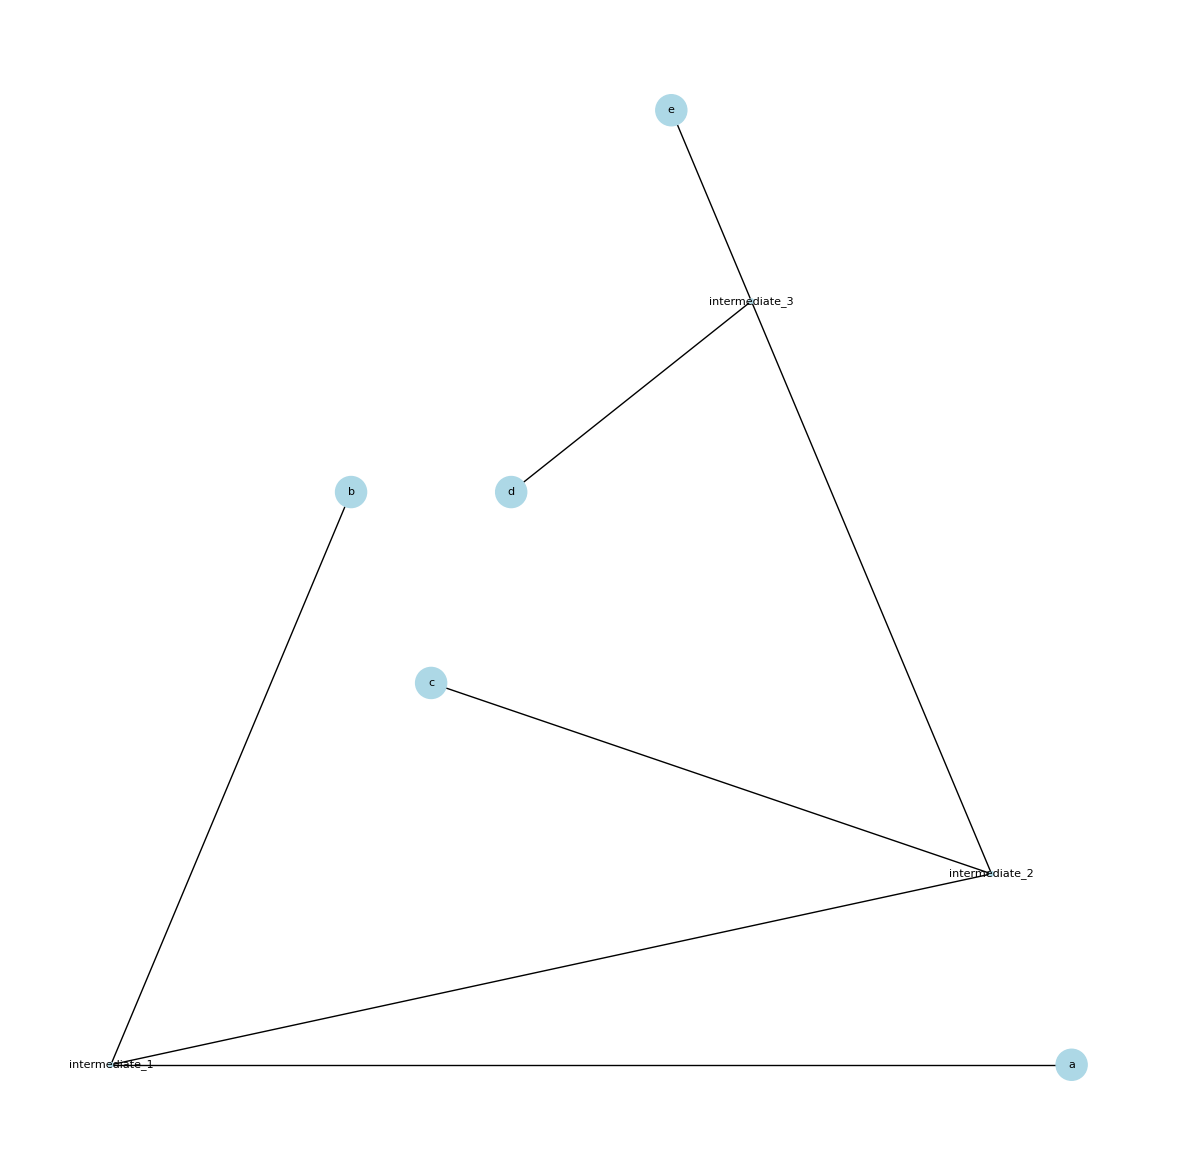

In [41]:
draw_graph_nice(theG)

In [42]:
# Get sequences
sequences, seq_names = utils.get_sequences_for_ancestry()
dis = create_matrix(sequences)
print(sequences)
print(seq_names)

seq_map = {}
for i, s in enumerate(seq_names):
    seq_map[s] = sequences[i]

['TGCACTCTCAGATCCTCATCTCGTTTCCATAGTTC', 'GGCGCTTCGTTCGCGTAAAGTCCCCCACCTACCGG', 'ACAATATCTCGGAACCACCACAGTGCTCTAGATAC', 'TTGCGTGGCAGAACCTAACCCGACAGTAGGCACTA', 'TCAGCGTCCGCTAGGCTAAGGCGTGAAGAGTAGCC', 'TCCGACCGACTAGCTTCGTACACTGCCAACCGCAT', 'TGACGCATGCTAATGCCCCAAAGTCTCGACAAGTC', 'TTGACGTAGATCCCCGTTGCATCGACAAGCATCAA', 'AGTTCAGGGATTGTAATTCGTCTGTAGAGTTGGGC', 'ACAATGAATGGTTGAATTGCCATACACGCGCTTAA', 'TGTGGTTCCTACCTGTCGCGTCTTTAAGGAAAGTC', 'TGTGTTGTAGCCAAAGCCGAATAATCTAATTAACG', 'TACAACCAAGCAAGCTGCAGGTGTAACGCGGTTGA', 'AGCAACTAGGTAATAAATTGCATGCAGGGCGTTCC', 'CACGCATGTTATTATGGCCCTCTATTGTATGCCCT']
['Ho-Oh', 'Toucannon', 'Stantler', 'Drapion', 'Vaporeon', 'Grumpig', 'Beheeyem', 'Snorlax', 'Doduo', 'Shaymin', 'Grovyle', 'Sawsbuck', 'Dunsparce', 'Slurpuff', 'Raichu']


{('intermediate_1', 'Grovyle'): 2.938461538461538, ('intermediate_1', 'Slurpuff'): 2.861538461538462, ('intermediate_1', 'intermediate_4'): 2.959999999999999, ('intermediate_2', 'Grumpig'): 3.041666666666667, ('intermediate_2', 'Doduo'): 4.158333333333333, ('intermediate_2', 'intermediate_8'): 0.93125, ('intermediate_3', 'Beheeyem'): 3.759090909090909, ('intermediate_3', 'Sawsbuck'): 3.840909090909091, ('intermediate_3', 'intermediate_11'): 1.0250000000000001, ('intermediate_4', 'Shaymin'): 5.040000000000001, ('intermediate_4', 'intermediate_5'): 3.0999999999999996, ('intermediate_5', 'Vaporeon'): 3.0999999999999996, ('intermediate_5', 'intermediate_6'): 3.1812500000000012, ('intermediate_6', 'Dunsparce'): 3.8187499999999988, ('intermediate_6', 'intermediate_7'): 3.7678571428571415, ('intermediate_7', 'Snorlax'): 0.5321428571428573, ('intermediate_7', 'intermediate_10'): 1.3101562499999992, ('intermediate_8', 'Toucannon'): 0.6687499999999996, ('intermediate_8', 'intermediate_13'): 0.15

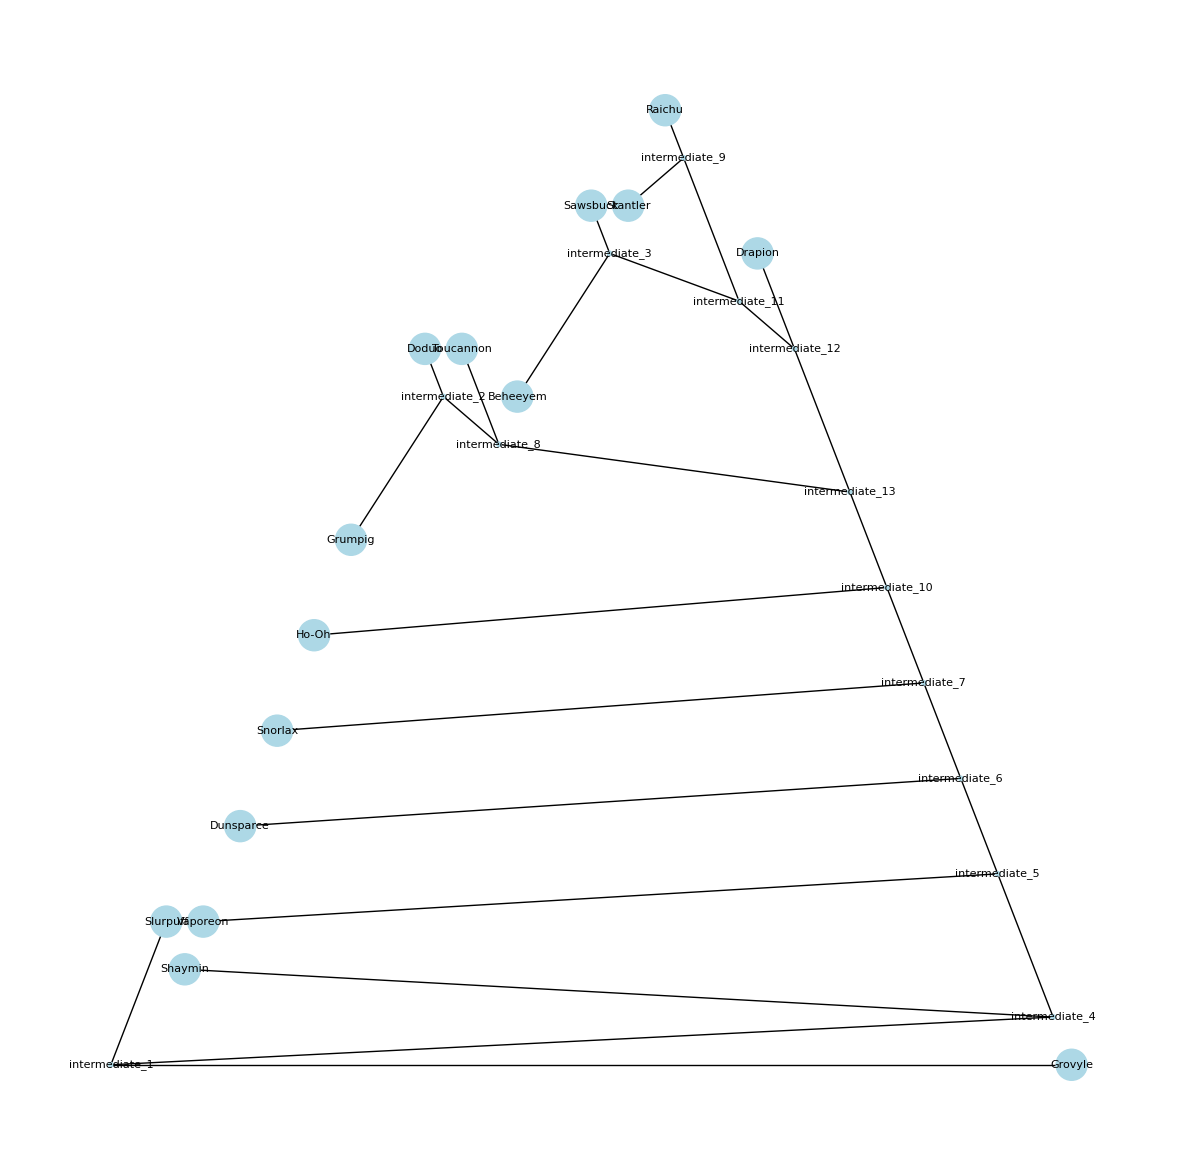

In [43]:
# Your code here
final_dict = collections.defaultdict(dict)
G = construct_alignment(dis, seq_names,1, final_dict)
theG = nx.Graph(final_dict)
draw_graph_nice(theG)
print(nx.get_edge_attributes(theG,"weight"))

<div class="alert alert-success">
    
**Problem 4 (b).** Given $n$ sequences each of roughly the same length $m$, what would the time complexity be for constructing such a phylogenetic tree? Can you think of any algorithms or heuristics that might make the process faster? 
    
</div>

The time complexity for constructing this phylogenetic tree is apporximately O(n^3). If you would like to add the section where we are finding the original distance matrix which is n^4. The neighbor joining algorithm could be reconstructed to become Θ(n^2) if we create the search for the minimum element into a tree. Another way we can make this faster is using the np vectorize function to split up the work for creating the array and avoiding the double for-loop. 

<div class="alert alert-success">

**Problem 4 (c).** Assume a direct correlation between the distance between any two nodes and the number of years (in millions) between their evolution. Assuming `Grumpig` was the first Pokémon to evolve, when did life first come to be in the fictional scenario?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

In [44]:
# Your code here
# one nucleotide pair in a thousand is randomly changed every 200,000 years.

In [45]:
how_long_ago = "???" # Replace with your answer
print(f"Life evolved {how_long_ago} million years ago in the Pokémon world")

Life evolved ??? million years ago in the Pokémon world


One way to test the robustness of such a tree reconstruction algorithm is to consider collection of nodes independently and see if the recontructed sub-trees match the bigger tree.

<div class="alert alert-success">
    
**Problem 4 (d).** Find an  edge between intermediate nodes with the largest weight in the phylogenetic tree and remove that edge- this will produce two disjoint cluster of nodes. Re-run your tree reconstruction algorithm on these two sets of Pokémons. Do your reconstructed tree match the larger phylogenetic tree?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

[('intermediate_9', 'intermediate_11'), 3.674999999999999]


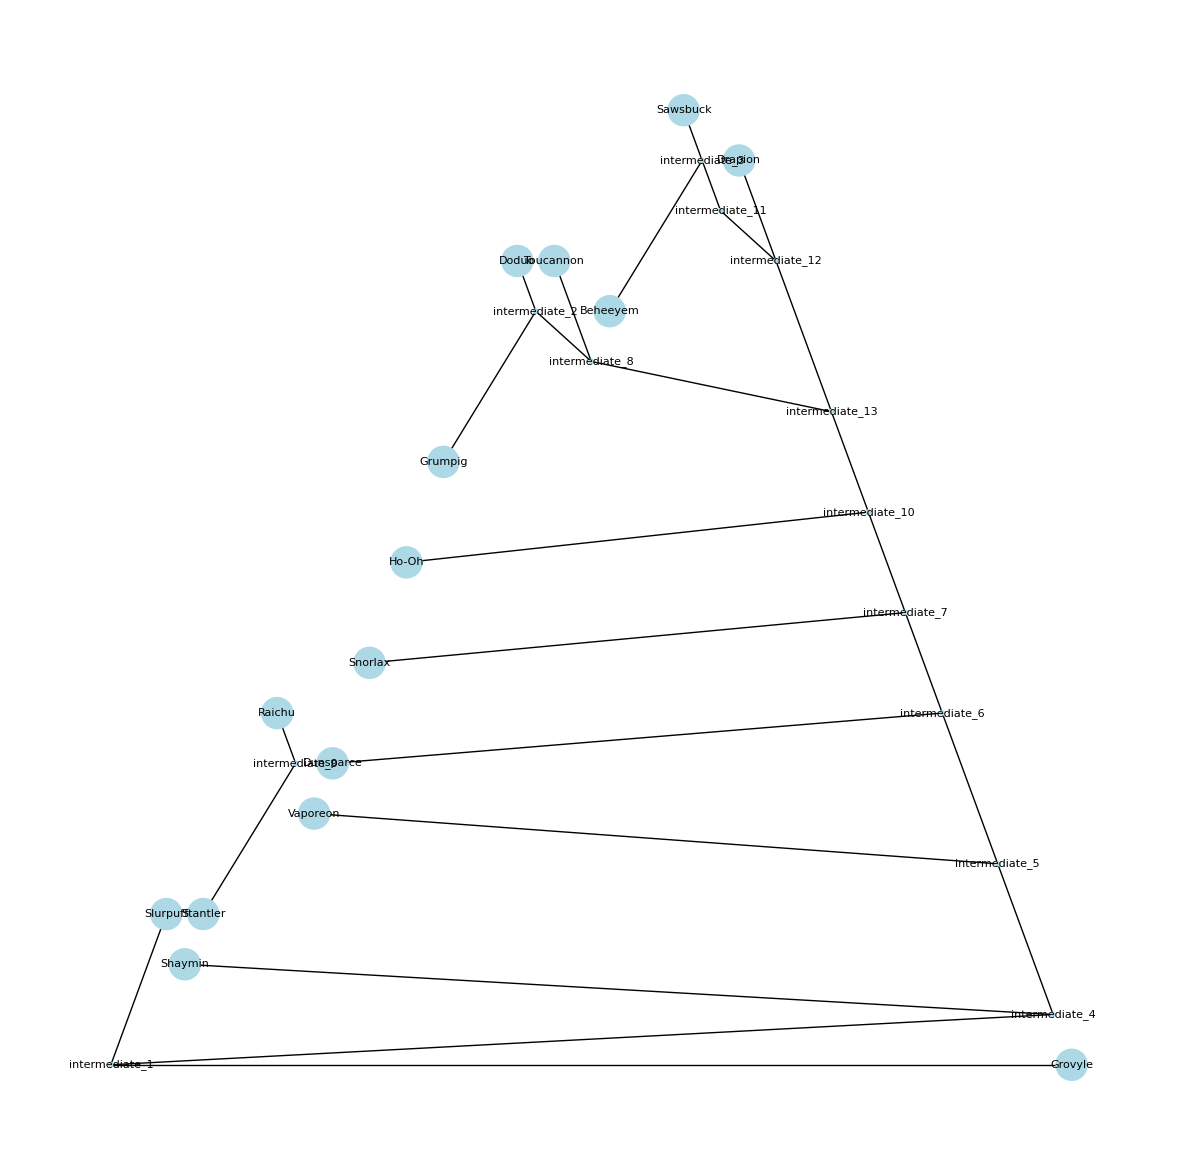

In [46]:
# Your code here
dict1 = nx.get_edge_attributes(theG,"weight")
list1 = [[k, v] for k, v in dict1.items()]

edge = max(filter(lambda node: "intermediate" in node[0][0] and "intermediate" in node[0][1], list1))
print(edge)

theG.remove_edge(edge[0][0], edge[0][1])
draw_graph_nice(theG)

In [48]:
cluster_1 = nx.descendants(theG, edge[0][0])
print(cluster_1)
cluster_2 = nx.descendants(theG, edge[0][1])
print(cluster_2)

{'Stantler', 'Raichu'}
{'Vaporeon', 'intermediate_5', 'Toucannon', 'intermediate_3', 'intermediate_4', 'Snorlax', 'intermediate_7', 'Doduo', 'intermediate_2', 'intermediate_12', 'intermediate_1', 'intermediate_6', 'intermediate_13', 'Grovyle', 'Shaymin', 'Beheeyem', 'Dunsparce', 'Slurpuff', 'Sawsbuck', 'Drapion', 'Ho-Oh', 'intermediate_8', 'Grumpig', 'intermediate_10'}


In [49]:
s1 = []
s1_names = list(cluster_1)
s2 = []
s2_names = list(cluster_2)

s1_names = [ x for x in s1_names if "intermediate" not in x ]
s2_names = [ x for x in s2_names if "intermediate" not in x ]

for s in s1_names:
    if s in seq_map:
        s1.append(seq_map[s])

for s in s2_names:
    if s in seq_map:
        s2.append(seq_map[s])
        
print(s1)
print(s1_names)
print(s2)
print(s2_names)



['ACAATATCTCGGAACCACCACAGTGCTCTAGATAC', 'CACGCATGTTATTATGGCCCTCTATTGTATGCCCT']
['Stantler', 'Raichu']
['TCAGCGTCCGCTAGGCTAAGGCGTGAAGAGTAGCC', 'GGCGCTTCGTTCGCGTAAAGTCCCCCACCTACCGG', 'TTGACGTAGATCCCCGTTGCATCGACAAGCATCAA', 'AGTTCAGGGATTGTAATTCGTCTGTAGAGTTGGGC', 'TGTGGTTCCTACCTGTCGCGTCTTTAAGGAAAGTC', 'ACAATGAATGGTTGAATTGCCATACACGCGCTTAA', 'TGACGCATGCTAATGCCCCAAAGTCTCGACAAGTC', 'TACAACCAAGCAAGCTGCAGGTGTAACGCGGTTGA', 'AGCAACTAGGTAATAAATTGCATGCAGGGCGTTCC', 'TGTGTTGTAGCCAAAGCCGAATAATCTAATTAACG', 'TTGCGTGGCAGAACCTAACCCGACAGTAGGCACTA', 'TGCACTCTCAGATCCTCATCTCGTTTCCATAGTTC', 'TCCGACCGACTAGCTTCGTACACTGCCAACCGCAT']
['Vaporeon', 'Toucannon', 'Snorlax', 'Doduo', 'Grovyle', 'Shaymin', 'Beheeyem', 'Dunsparce', 'Slurpuff', 'Sawsbuck', 'Drapion', 'Ho-Oh', 'Grumpig']


_Type your answer here_

{('intermediate_0', 'Raichu'): 0}
{('intermediate_1', 'Vaporeon'): 3.0000000000000013, ('intermediate_1', 'Snorlax'): 4.199999999999999, ('intermediate_1', 'intermediate_9'): 0.633333333333333, ('intermediate_2', 'Grovyle'): 2.96, ('intermediate_2', 'Slurpuff'): 2.84, ('intermediate_2', 'intermediate_7'): 1.1399999999999986, ('intermediate_3', 'Sawsbuck'): 3.4555555555555557, ('intermediate_3', 'Ho-Oh'): 2.7444444444444436, ('intermediate_3', 'intermediate_6'): 3.2749999999999995, ('intermediate_4', 'Doduo'): 0.9250000000000007, ('intermediate_4', 'Dunsparce'): 3.5749999999999993, ('intermediate_4', 'intermediate_5'): 3.2357142857142858, ('intermediate_5', 'Grumpig'): 3.7642857142857142, ('intermediate_5', 'intermediate_7'): 4.16, ('intermediate_6', 'Drapion'): 4.7250000000000005, ('intermediate_6', 'intermediate_11'): 0.9218749999999998, ('intermediate_7', 'intermediate_10'): 3.6781249999999996, ('intermediate_8', 'Toucannon'): 0.08750000000000036, ('intermediate_8', 'Shaymin'): 0.762

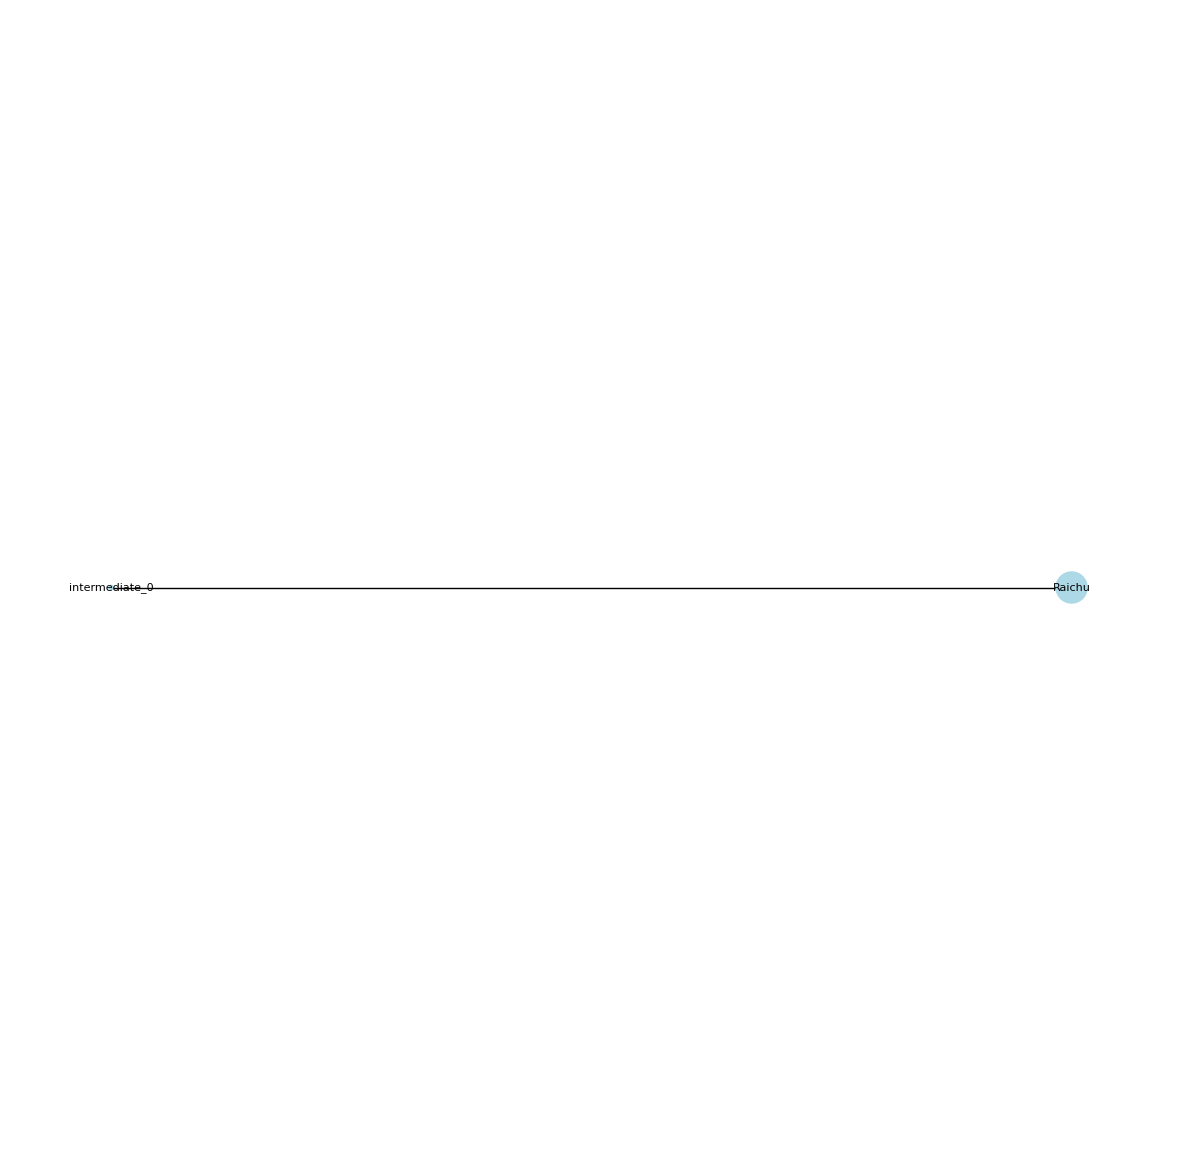

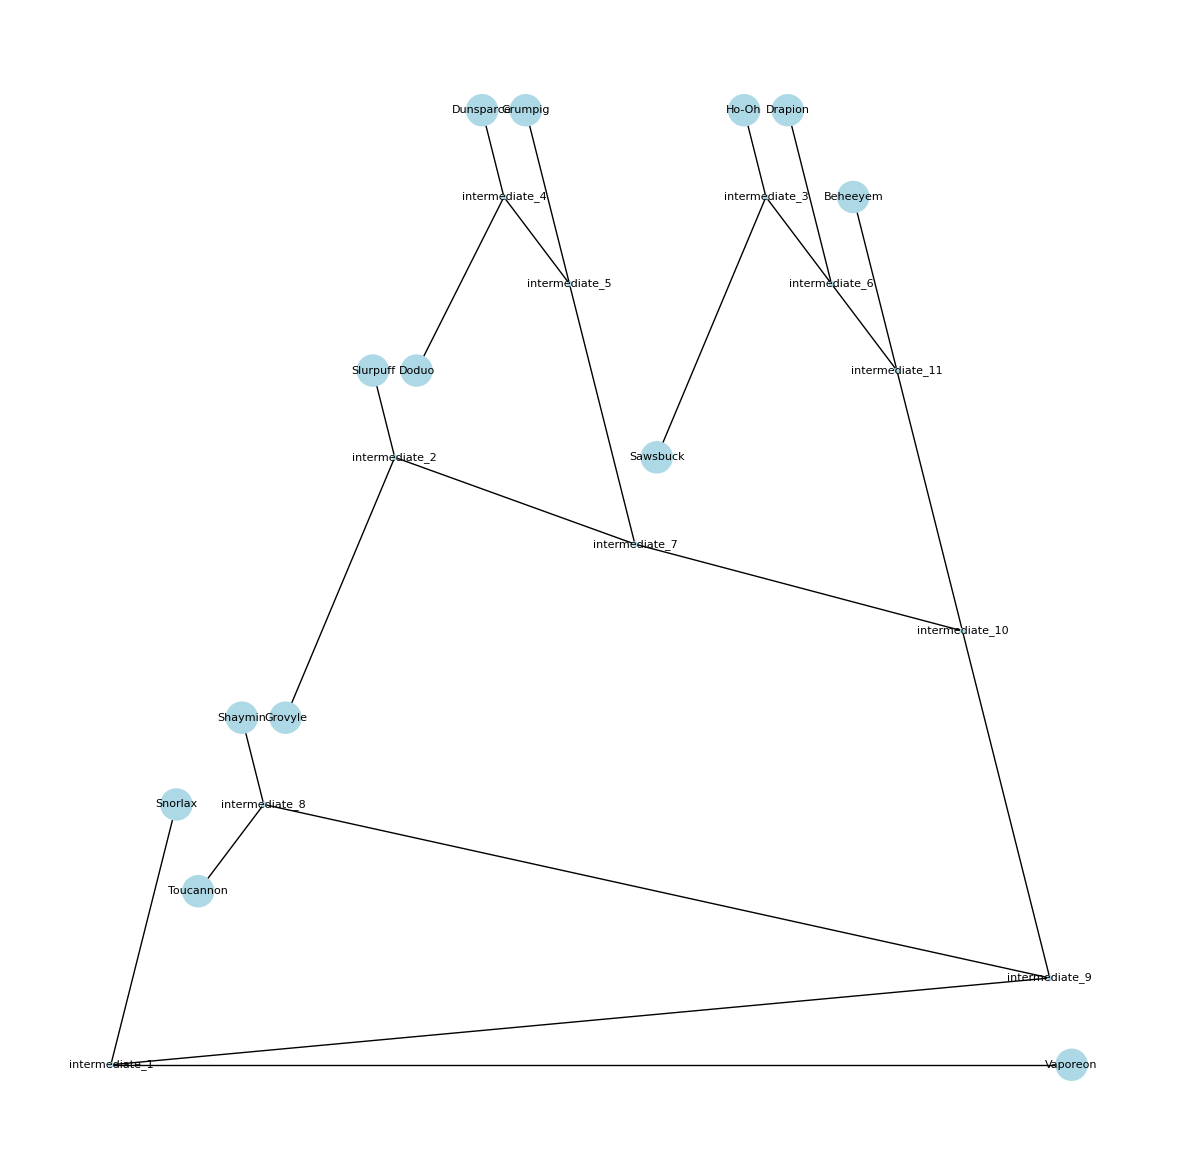

In [50]:
dis1 = create_matrix(s1)

final_dict1 = collections.defaultdict(dict)
G = construct_alignment(dis1, s1_names,1, final_dict1)
theG1 = nx.Graph(final_dict1)
draw_graph_nice(theG1)


print(nx.get_edge_attributes(theG1,"weight"))

dis2 = create_matrix(s2)

final_dict2 = collections.defaultdict(dict)
G = construct_alignment(dis2, s2_names,1, final_dict2)
theG2 = nx.Graph(final_dict2)
draw_graph_nice(theG2)


print(nx.get_edge_attributes(theG2,"weight"))

<div class="alert alert-success">

**Problem 4 (d).** Can you inspect the matrix of distances between the Pokémons and predict whether the reconstructed trees would always be unique? Why/why not?
</div>

_Type your answer here_

## Part 5: Tracing Evolution

<div class="alert alert-warning">
    This problem is a "Challenge Problem". This means it is a problem of unknown difficulty that might be quite challenging (unlike the earlier problems, we don't have a reference solution for this one, or a clear idea how hard it might be). We do hope all students will at least attempt this and that more ambitious students will work hard to solve it and learn interesting things by the attempt (whether or not it is successful), but not get frustrated if you can't get to the desired answer.  As a "Challenge Problem" it means that you shouldn't be worried if you are not able to solve this, though, and you can get full expected credit on this assignment without answering it.
</div>


Now that we can construct Phylogenetic trees using sequence alignment, we can attempt to construct these trees for different organisms and trace their evolution through time. You're given reads processed from a FASTA file for Hemoglobin Beta Proteins, which can be used to then trace evolution based on how similar their sequences are across organisms from different kingdoms. Each record has the following relevant information in Tuple format:

`((uniprot identifier, full name, shortened name, group), (sequence))`

As you may notice, running our nearest-neighbor reconstruction algorithm on this data will give a Phylogenetic tree that does not fully correspond to what we know about the evolution of these species.

<div class="alert alert-success">
    
**Problem 8 (Challenge).** Construct a Phylogenetic Tree using the given sequences. Implement and use any tree-reconstruction method of your choice, and see if it works better than the nearest-neighbor method with a linear-gap penalty.
    
For visualization, use the short name to display in the evolution tree.
    
</div>
    
This is an open-ended question, and is inspired by https://www.mimuw.edu.pl/~lukaskoz/teaching/sad2/lab6/readme.html. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have.

In [28]:
sequences = utils.get_sequences_for_tree()
print(sequences[0])

(('P01941.1', 'Tupaia glis', 'Tgli', 'Mammalia'), 'VLSPGDKSNIKAAWGKIGGQAPQYGAEALERMFLSFPTTKTYFPHFDMSHGSAQIQAHGKKVADALSTAVGHLDDLPTALSALSDLHAHKLRVDPANFKLLSHCILVTLACHHPGDFTPEIHASLDKFLANVSTVLTSKYR')


In [ ]:
# Your code here

_Write a description of your algorithm, and things you learned from working on this here._

_Type your answer here_

<div class="alert alert-success">
    
Is this (using Hemoglobin proteins) the best way to trace and visualize evolution? Why do you think it is useful, and what could the possible downsides of this be?
    
</div>

_Type your answer here_

   <div class="alert alert-block alert-danger">
    <center>
      
**End of Project 2!**
        
Remember to follow the submission directions above to submit your assignment.
    
 </center>
 </div>